# TD5: volatility prediction

## 1: realized volatility and prediction with rough volatility model

The following code is adapted from [this page](https://tpq.io/p/rough_volatility_with_python.html). The data format has changed, and the code now runs with Python 3.

In [21]:
!pip3 install --upgrade tensorflow-gpu
import tensorflow as tf
tf.test.gpu_device_name()

     |████████████████████████████████| 394.3MB 40kB/s 


'/device:GPU:0'

In [75]:
import warnings; warnings.simplefilter('ignore')
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
from sklearn import datasets, linear_model
import scipy.special as scsp
import statsmodels.api as sm
import math
import seaborn as sns; sns.set()
%matplotlib inline
from tqdm import tqdm_notebook as tqdm

In [76]:
# How I obtained the data

#url = 'https://realized.oxford-man.ox.ac.uk/images/oxfordmanrealizedvolatilityindices.zip'
#DF=pd.read_csv(url,index_col=0 )

#parquet is a modern, fast data format for tables. Install pyarrow

#DF.to_parquet("../data/oxfordmanrealizedvolatilityindices.parquet")  # I also converted the index to datetime

In [77]:
import pyarrow.parquet as pq

In [78]:
# Import de nos drive pour les fichiers
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
# advised: download the data file from the course webpage
import pyarrow.parquet as pq

import io
DF = pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/oxfordmanrealizedvolatilityindices.csv.gz',compression='gzip',index_col=0)
DF

,Symbol,close_price,open_to_close,medrv,rsv,rv5,rv10_ss,rv5_ss,bv_ss,rk_twoscale,open_price,bv,open_time,rv10,rk_parzen,close_time,rk_th2,rsv_ss,nobs
2000-01-03 00:00:00+00:00,.AEX,675.44,-0.000340,0.000050,0.000046,0.000130,0.000178,0.000130,0.000100,0.000103,675.67,0.000100,90101.0,0.000178,0.000179,163015.0,0.000102,0.000046,1795.0
2000-01-04 00:00:00+00:00,.AEX,642.25,-0.033606,0.000075,0.000147,0.000201,0.000261,0.000201,0.000207,0.000199,664.20,0.000207,90416.0,0.000261,0.000423,163016.0,0.000201,0.000147,1785.0
2000-01-05 00:00:00+00:00,.AEX,632.31,-0.001675,0.000166,0.000328,0.000491,0.000714,0.000491,0.000361,0.000325,633.37,0.000361,90016.0,0.000714,0.000324,163016.0,0.000345,0.000328,1801.0
2000-01-06 00:00:00+00:00,.AEX,624.21,-0.013130,0.000152,0.000116,0.000225,0.000182,0.000225,0.000258,0.000218,632.46,0.000258,90016.0,0.000182,0.000219,163002.0,0.000221,0.000116,1799.0
2000-01-07 00:00:00+00:00,.AEX,644.86,0.025013,0.000039,0.000048,0.000138,0.000157,0.000138,0.000130,0.000126,628.93,0.000130,90046.0,0.000157,0.000155,163016.0,0.000123,0.000048,1798.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-11 00:00:00+00:00,.STOXX50E,3668.43,0.003848,0.000013,0.000014,0.000028,0.000021,0.000028,0.000027,0.000032,3654.34,0.000027,90015.0,0.000021,0.000009,173015.0,0.000033,0.000014,4255.0
2021-02-12 00:00:00+00:00,.STOXX50E,3695.01,0.007053,0.000014,0.000014,0.000031,0.000036,0.000031,0.000032,0.000031,3669.04,0.000032,90015.0,0.000036,0.000026,173002.0,0.000032,0.000014,4157.0
2021-02-15 00:00:00+00:00,.STOXX50E,3738.69,0.007340,0.000008,0.000006,0.000024,0.000021,0.000024,0.000021,0.000020,3711.35,0.000021,90015.0,0.000021,0.000016,173001.0,0.000021,0.000006,4236.0
2021-02-16 00:00:00+00:00,.STOXX50E,3725.56,-0.002673,0.000012,0.000013,0.000026,0.000026,0.000026,0.000026,0.000028,3735.53,0.000026,90015.0,0.000026,0.000010,173002.0,0.000028,0.000013,4224.0


In [80]:
DF["Symbol"].unique()

array(['.AEX', '.AORD', '.BFX', '.BSESN', '.BVLG', '.BVSP', '.DJI',
       '.FCHI', '.FTMIB', '.FTSE', '.GDAXI', '.GSPTSE', '.HSI', '.IBEX',
       '.IXIC', '.KS11', '.KSE', '.MXX', '.N225', '.NSEI', '.OMXC20',
       '.OMXHPI', '.OMXSPI', '.OSEAX', '.RUT', '.SMSI', '.SPX', '.SSEC',
       '.SSMI', '.STI', '.STOXX50E'], dtype=object)

'rk_twoscale' Realized kernel variance (Two Scales Bartlet).

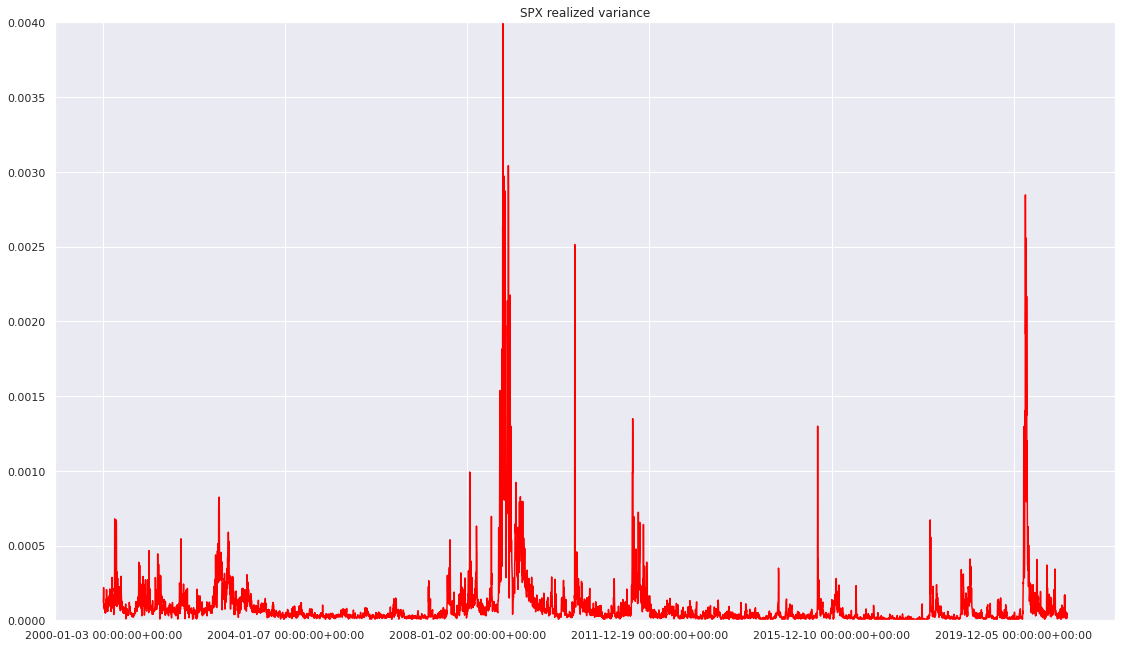

In [81]:
spx=DF[DF["Symbol"]==".SPX"]
spx["rk_twoscale"].plot(color='red', grid=True, title='SPX realized variance',
         figsize=(19, 11), ylim=(0,0.004));

In [82]:
spx['sqrt']= np.sqrt(spx['rk_twoscale']) # racine de la relazied variance cad la Vol
spx['log_sqrt'] = np.log(spx['sqrt']) # la log Vol

def del_Raw(q, x): 
    return [np.mean(np.abs(spx['log_sqrt'] - spx['log_sqrt'].shift(lag)) ** q)
            for lag in x]

[0.08495158289730478, 0.16930164043370957, 0.25320521325596695, 0.3368248767606619, 0.5034614329671553]


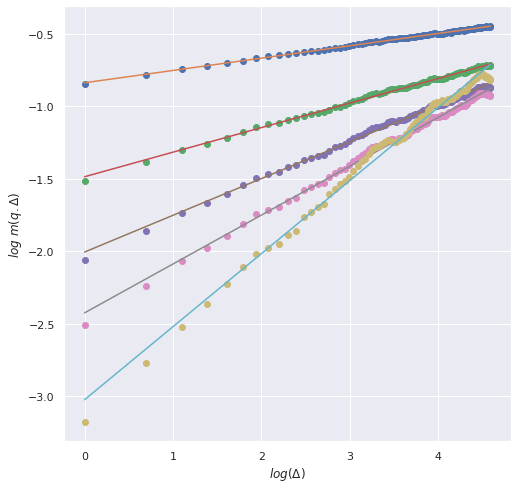

In [83]:
plt.figure(figsize=(8, 8))
plt.xlabel('$log(\Delta)$')
plt.ylabel('$log\  m(q.\Delta)$')
plt.ylim=(-3, -.5)

zeta_q = list()
qVec = np.array([.5, 1, 1.5, 2, 3])
x = np.arange(1, 100)
for q in qVec:
    plt.plot(np.log(x), np.log(del_Raw(q, x)), 'o') 
    model = np.polyfit(np.log(x), np.log(del_Raw(q, x)), 1)
    plt.plot(np.log(x), np.log(x) * model[0] + model[1])
    zeta_q.append(model[0])
    
print(zeta_q)

0.16790469088246576


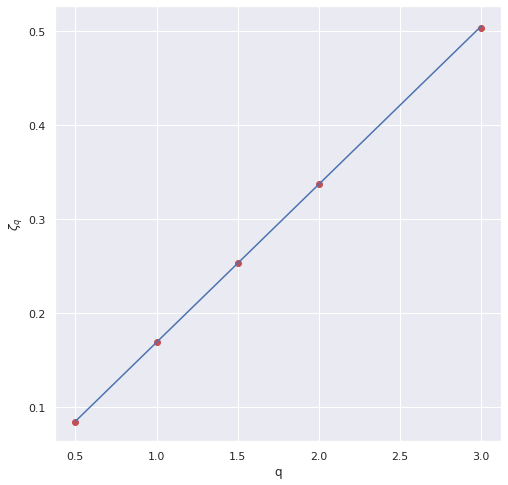

In [84]:
plt.figure(figsize=(8,8))
plt.xlabel('q')
plt.ylabel('$\zeta_{q}$')
plt.plot(qVec, zeta_q, 'or')

line = np.polyfit(qVec[:4], zeta_q[:4],1)
plt.plot(qVec, line[0] * qVec + line[1])
h_est= line[0]
print(h_est)

In [85]:
def dlsig2(sig, x, pr=False):
    if pr:
        a= np.array([(sig-sig.shift(lag)).dropna() for lag in x])
        a=a ** 2
        print(a.info())
    return [np.mean((sig-sig.shift(lag)).dropna() ** 2) for lag in x]

In [86]:
h = list()
nu = list()

for mysymbol in DF["Symbol"].unique():
    sig=DF[DF["Symbol"]==mysymbol]["rk_twoscale"]
    sig = np.log(np.sqrt(sig))
    sig = sig.dropna()
    model = np.polyfit(np.log(x), np.log(dlsig2(sig, x)), 1)
    nu.append(np.sqrt(np.exp(model[1])))
    h.append(model[0]/2.)
    
OxfordH = pd.DataFrame({'Symbol':DF["Symbol"].unique(), 'h_est': h, 'nu_est': nu})

### Variance forecasts

In [87]:
import pdb
def c_tilde(h):
    return scsp.gamma(3. / 2. - h) / scsp.gamma(h + 1. / 2.) * scsp.gamma(2. - 2. * h)

def forecast_XTS(rvdata, h, date, nLags, delta, nu):
    i = np.arange(nLags)
    cf = 1./((i + 1. / 2.) ** (h + 1. / 2.) * (i + 1. / 2. + delta))
    ldata = pd.DataFrame(rvdata.truncate(after=date))

    l = len(ldata)
    ldata = np.log(ldata[l - nLags:])

    ldata['cf'] = np.fliplr([cf])[0]
    # print ldata
    ldata = ldata.dropna()
    fcst = (ldata.iloc[:, 0] * ldata['cf']).sum() / sum(ldata['cf'])    
    return math.exp(fcst + 2 * nu ** 2 * c_tilde(h) * delta ** (2 * h))

In [88]:
mysymbol=".SPX"

rvdata=DF[DF["Symbol"]==mysymbol]["rk_twoscale"]

In [89]:
fit_symbol =OxfordH[OxfordH["Symbol"]==mysymbol]
nu  = fit_symbol['nu_est'] # Vol of vol estimate for SPX
h = fit_symbol["h_est"].values
n = len(rvdata)
delta = 1
nLags = 5
dates = rvdata.iloc[nLags:n-delta].index

In [90]:
rv_predict = [forecast_XTS(rvdata, h=h, date=d, nLags=nLags,
                           delta=delta, nu=nu) for d in tqdm(dates)]
rv_actual = rvdata.iloc[nLags+delta:n].values


In [91]:
delta = 1
nLags = 500
dates = rvdata.iloc[nLags:n-delta].index
rv_predict = [forecast_XTS(rvdata, h=h, date=d, nLags=nLags,
                           delta=delta, nu=nu) for d in tqdm(dates)]
rv_actual = rvdata.iloc[nLags+delta:n].values
#rv_actual = rvdata.iloc[nLags+delta:n]

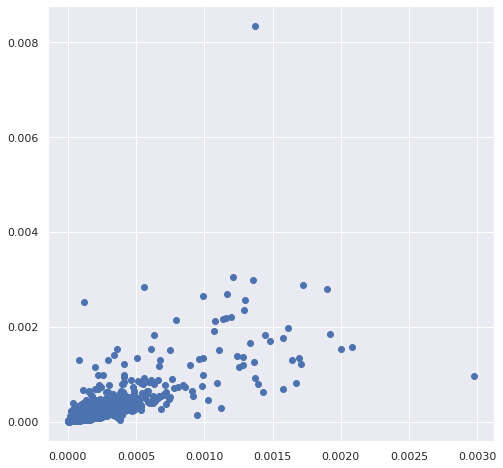

In [92]:
plt.figure(figsize=(8, 8))
#plt.plot(rv_predict, rv_actual, 'bo');
plt.plot(rv_predict,rv_actual, 'bo');

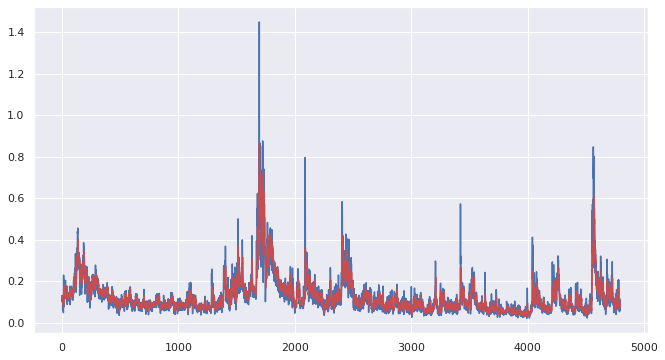

In [93]:
plt.figure(figsize=(11, 6))
vol_actual = np.sqrt(np.multiply(rv_actual,252))
vol_predict = np.sqrt(np.multiply(rv_predict,252))
plt.plot(vol_actual, "b")
plt.plot(vol_predict, "r");

In [94]:
Baseline = pd.DataFrame.from_dict({'Dates' : dates , 'vol_actual' : rv_actual , 'rough_pred' : rv_predict})
Baseline

,Dates,vol_actual,rough_pred
0,2002-01-08 00:00:00+00:00,0.000064,0.000060
1,2002-01-09 00:00:00+00:00,0.000061,0.000065
2,2002-01-10 00:00:00+00:00,0.000066,0.000065
3,2002-01-11 00:00:00+00:00,0.000040,0.000068
4,2002-01-14 00:00:00+00:00,0.000053,0.000054
...,...,...,...
4789,2021-02-09 00:00:00+00:00,0.000055,0.000019
4790,2021-02-10 00:00:00+00:00,0.000032,0.000039
4791,2021-02-11 00:00:00+00:00,0.000013,0.000035
4792,2021-02-12 00:00:00+00:00,0.000032,0.000023


In [95]:
Baseline.to_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev.csv')

### 1.2 Estimation GARCH(p,q)

In [ ]:
!pip install git+https://github.com/RJT1990/pyflux

In [ ]:
spx['log_ret'] = 0 
spx['log_ret'][1:] =  np.diff(np.log(spx['close_price'].values))
spx

,Symbol,close_price,open_to_close,medrv,rsv,rv5,rv10_ss,rv5_ss,bv_ss,rk_twoscale,open_price,bv,open_time,rv10,rk_parzen,close_time,rk_th2,rsv_ss,nobs,sqrt,log_sqrt,log_ret
2000-01-03 00:00:00+00:00,.SPX,1454.24,-0.011602,0.000058,0.000096,0.000141,0.000164,0.000141,0.000141,0.000122,1471.21,0.000141,83004.0,0.000164,0.000340,145959.0,0.000130,0.000096,1554.0,0.011033,-4.506843,0.000000
2000-01-04 00:00:00+00:00,.SPX,1399.02,-0.035102,0.000067,0.000180,0.000224,0.000295,0.000224,0.000173,0.000142,1449.00,0.000173,83009.0,0.000295,0.000215,150000.0,0.000162,0.000180,1564.0,0.011930,-4.428714,-0.038711
2000-01-05 00:00:00+00:00,.SPX,1402.09,0.004625,0.000142,0.000131,0.000314,0.000267,0.000314,0.000303,0.000219,1395.62,0.000303,83012.0,0.000267,0.000163,150003.0,0.000240,0.000131,1552.0,0.014800,-4.213107,0.002192
2000-01-06 00:00:00+00:00,.SPX,1403.06,0.002991,0.000070,0.000056,0.000131,0.000115,0.000131,0.000128,0.000127,1398.87,0.000128,83005.0,0.000115,0.000067,145954.0,0.000132,0.000056,1561.0,0.011251,-4.487290,0.000692
2000-01-07 00:00:00+00:00,.SPX,1440.84,0.026293,0.000049,0.000023,0.000094,0.000121,0.000094,0.000079,0.000091,1403.45,0.000079,83000.0,0.000121,0.000215,150000.0,0.000095,0.000023,1540.0,0.009535,-4.652832,0.026571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-10 00:00:00+00:00,.SPX,3910.02,-0.002748,0.000018,0.000050,0.000078,0.000054,0.000078,0.000077,0.000055,3920.78,0.000077,83001.0,0.000054,0.000065,150001.0,0.000053,0.000050,23401.0,0.007407,-4.905287,-0.000299
2021-02-11 00:00:00+00:00,.SPX,3916.28,-0.000031,0.000015,0.000026,0.000043,0.000042,0.000043,0.000033,0.000032,3916.40,0.000033,83001.0,0.000042,0.000033,150001.0,0.000031,0.000026,23401.0,0.005645,-5.177072,0.001600
2021-02-12 00:00:00+00:00,.SPX,3935.07,0.005969,0.000007,0.000004,0.000015,0.000012,0.000015,0.000014,0.000013,3911.65,0.000014,83001.0,0.000012,0.000017,150001.0,0.000013,0.000004,23401.0,0.003573,-5.634475,0.004786
2021-02-16 00:00:00+00:00,.SPX,3932.25,-0.001870,0.000016,0.000023,0.000042,0.000030,0.000042,0.000041,0.000032,3939.61,0.000041,83001.0,0.000030,0.000018,150000.0,0.000032,0.000023,23400.0,0.005690,-5.168998,-0.000717


In [ ]:
! pip install arch 

     |████████████████████████████████| 808kB 17.9MB/s 


ARCH models are a popular class of volatility models that use observed values of returns or residuals as volatility shocks. A basic GARCH model is specified as:
- $r_{t} = \mu + \epsilon_{t}$ \\
$ \epsilon_{t} = \sigma_{t}e_{t}$ \\
$ \sigma_{t}^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$



In [ ]:
print(f"Le nombre de ligne du Dataframe est {spx['log_ret'].shape[0]}.")

Le nombre de ligne du Dataframe est 5295.


In [ ]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings

We will use a rolling window to predict the volatiltiy. 

- The actual predctions with rought volatiltiy model are done from "2002-01-08" to "2021-02-16".In our case the SP500 returns began in "2000".
- We will use a first Training sample form the from the first observation to the 500 th obsevation and we will save only prediction from this date the end date of the dataset.

- We want to comapre methodologies for forecasting volatltiy so we haves to compare our resultats on a same database.

<img src='https://drive.google.com/uc?id=10DYu4uccQ9T2brLQBSAOMityHb_h-uXg' width="300" height="150">


In [ ]:
Train_size = spx[spx.index < Baseline.Dates[0]]['log_ret'].shape[0]
dT = 10; Garch_pred = list() ; Dates_pred = list()
for  i in tqdm(range(0,Baseline.Dates.shape[0]-dT+1,dT)):
# Specify GARCH model assumptions
  basic_gm = arch_model(spx[spx.index < Baseline.Dates[i]]['log_ret'].values[-Train_size:], p = 10, q = 10,
                        mean = 'constant', vol = 'GARCH', dist = 'normal');
  gm_result = basic_gm.fit(update_freq = dT);# Fit the model
  forecast = gm_result.forecast(horizon= dT).variance;
  Garch_pred.append(np.sqrt(np.multiply(forecast.iloc[-1,:].values,252)));
  Dates_pred.append(Baseline.Dates[i])
np.array(Garch_pred).flatten()

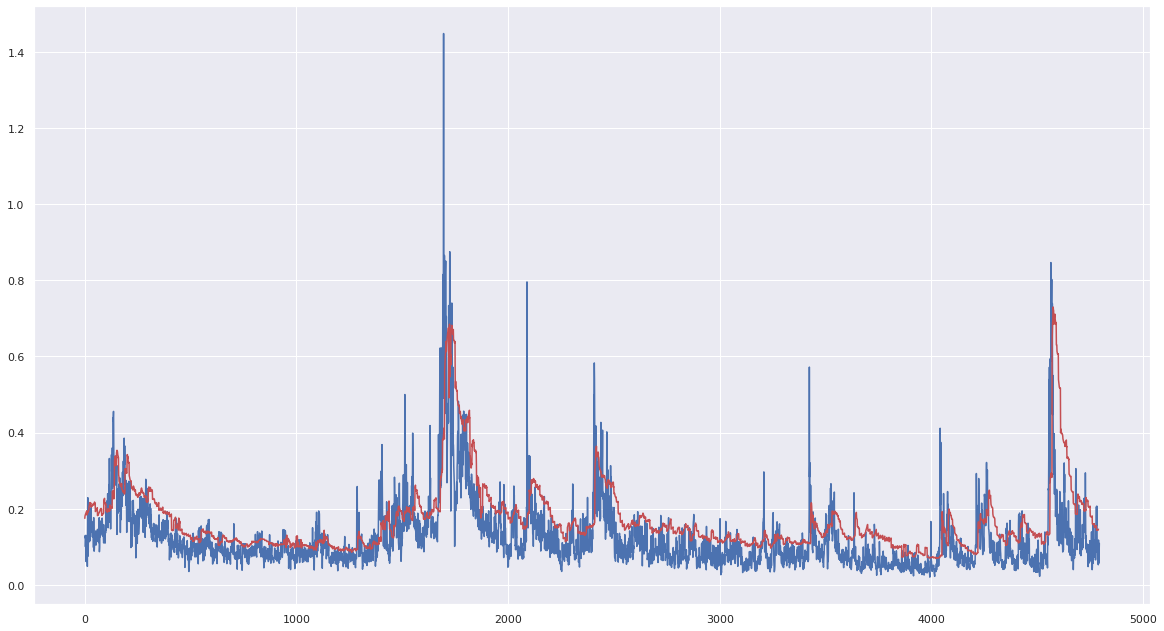

In [ ]:
plt.figure(figsize=(20, 11))
vol_actual = np.sqrt(np.multiply(rv_actual,252))
vol_predict = np.array(Garch_pred).flatten() ## is already annualized in the loop above
plt.plot(vol_actual, "b")
plt.plot(vol_predict, "r");

In [ ]:
Baseline['Garch_pred'] = np.array(Garch_pred).flatten() 

In [ ]:
Baseline.to_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev.csv')

## 2 Deep Learning

In [ ]:
Baseline

,Dates,vol_actual,rough_pred
0,2002-01-08 00:00:00+00:00,0.000064,0.000060
1,2002-01-09 00:00:00+00:00,0.000061,0.000065
2,2002-01-10 00:00:00+00:00,0.000066,0.000065
3,2002-01-11 00:00:00+00:00,0.000040,0.000068
4,2002-01-14 00:00:00+00:00,0.000053,0.000054
...,...,...,...
4789,2021-02-09 00:00:00+00:00,0.000055,0.000019
4790,2021-02-10 00:00:00+00:00,0.000032,0.000039
4791,2021-02-11 00:00:00+00:00,0.000013,0.000035
4792,2021-02-12 00:00:00+00:00,0.000032,0.000023


- Dans cette partie on met les données sous le format d'entrée du reseaux LSTM.

In [52]:
#split a univariate sequence into samples
def split_sequence_univariate(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
            
        # gather input and output parts of the pattern
        #seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix, -1]
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


# Transforms a 2d-X and y to 3d X and y


# split a multivariate sequence into samples
def split_sequences_multivariate(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
# find the end of this pattern
        end_ix = i + n_steps
# check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
# gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [53]:
import numpy as np
import matplotlib.pyplot as plt

In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Activation, Reshape,Flatten, Dropout, Lambda, RepeatVector
from tensorflow.keras.layers import Add,Multiply
from tensorflow.keras.optimizers import Adam

gpu_devices = tf.config.experimental.list_physical_devices('GPU')  # allow memory use to grow
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)


In [55]:
def Generic_LSTM (Nb_neurons,batch_size,sizesamples,summary = False):

  
  model = Sequential()
  model.add(LSTM(units = Nb_neurons , batch_input_shape=(batch_size,sizesamples[1],sizesamples[2]),return_sequences=True, stateful=True))
  model.add(Dropout(0.2))
  # Adding a second LSTM layer and some Dropout regularisation
  model.add(LSTM(units = Nb_neurons ,return_sequences=True, stateful=True))
  model.add(Dropout(0.2))
  # Adding a third LSTM layer and some Dropout regularisation
  model.add(LSTM(units = Nb_neurons ,return_sequences=True, stateful=True))
  model.add(Dropout(0.2))
  # Adding a fourth LSTM layer and some Dropout regularisation
  model.add(LSTM(units = Nb_neurons, stateful=True))
  model.add(Dropout(0.2))
  # Adding the output layer
  model.add(Dense(units = 1))
  Opt = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07) ## Valeurs par defaults ;
  model.compile(optimizer = Opt, loss = 'mse')
  if summary == True :
    model.summary()

  return model

In [56]:
def Global_LSTM(batch_size,T_in,dT,nb_epochs,neurons_lstm,X,Y,type = 'regression',shfle = False):

      LSTM_Training =  Generic_LSTM(neurons_lstm, batch_size, X.shape,summary = False) 
      if type ==   'classification' : 
        LSTM_History = np.array([0]*Y.shape[1],ndmin=2)
      else: 
        LSTM_History = np.array([])

      for t in tqdm(np.arange(T_in,X.shape[0]-T_in,dT)):

          LSTM_Training.fit(X[t-T_in:t],Y[t-T_in:t], batch_size = batch_size, epochs = nb_epochs , shuffle = shfle,verbose=0)
          LSTM_Forecast = Generic_LSTM(neurons_lstm, dT, X.shape) ; LSTM_Forecast.set_weights(LSTM_Training.get_weights())
          forecast = LSTM_Forecast.predict(X[t:t+dT],batch_size=dT) ; LSTM_History = np.concatenate((LSTM_History, forecast.flatten()), axis=0) ## Rajoute les nouvelles predictions

      return LSTM_History

In [57]:
def Generic_GRU (Nb_neurons,batch_size,sizesamples,summary = False):

  
  model = Sequential()
  model.add(GRU(units = Nb_neurons , batch_input_shape=(batch_size,sizesamples[1],sizesamples[2]),return_sequences=True, stateful=True))
  model.add(Dropout(0.2))
  # Adding a second LSTM layer and some Dropout regularisation
  model.add(GRU(units = Nb_neurons ,return_sequences=True, stateful=True))
  model.add(Dropout(0.2))
  # Adding a third LSTM layer and some Dropout regularisation
  model.add(GRU(units = Nb_neurons ,return_sequences=True, stateful=True))
  model.add(Dropout(0.2))
  # Adding a fourth LSTM layer and some Dropout regularisation
  model.add(GRU(units = Nb_neurons, stateful=True))
  model.add(Dropout(0.2))
  # Adding the output layer
  model.add(Dense(units = 1))
  Opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) ## Valeurs par defaults ;
  model.compile(optimizer = Opt, loss = 'mse')
  if summary == True :
    model.summary()

  return model

In [58]:
def Global_GRU(batch_size,T_in,dT,nb_epochs,neurons_lstm,X,Y,type = 'regression',shfle = False):

      GRU_Training =  Generic_GRU(neurons_lstm, batch_size, X.shape,summary = False) 
      if type ==   'classification' : 
        GRU_History = np.array([0]*Y.shape[1],ndmin=2)
      else: 
        GRU_History = np.array([])

      for t in tqdm(np.arange(T_in,X.shape[0]-T_in,dT)):

          GRU_Training.fit(X[t-T_in:t],Y[t-T_in:t], batch_size = batch_size, epochs = nb_epochs , shuffle = shfle,verbose=0)
          GRU_Forecast = Generic_GRU(neurons_lstm, dT, X.shape) ; GRU_Forecast.set_weights(GRU_Training.get_weights())
          forecast = GRU_Forecast.predict(X[t:t+dT],batch_size=dT) ; 
          GRU_History = np.concatenate((GRU_History, forecast.flatten()), axis=0) ## Rajoute les nouvelles predictions

      return GRU_History

In [ ]:
X_full = np.log(spx[["rk_twoscale"]].values)   # np.log(Baseline[['vol_actual']].values)  
N_I=100 # length of sequences input to LSTMs
X_sample,y_sample=split_sequence_univariate(X_full,N_I)   # for LSTMs
print(f"Shape of LSTM Inputs : {X_sample.shape}")# we do have a 3d-object
print(f"Shape of LSTM Inputs Labels :{y_sample.shape}")

Shape of LSTM Inputs : (5195, 100, 1)
Shape of LSTM Inputs Labels :(5195, 1)


Dans cette partie nous avons detaillé la construction d'un LSTM appliquée au cas des series temporelles.Dans notre cas il est important de comprendre les differents hyperparametres a utiliser : 

- Nous utilisont un deep LSTM c est dire un reseau multicouches . La tailles de chaque sample utilisé dans notre cas est de 100 et necessite donc d'utiliser une couche d'entrée de 100 neurones. Ce reseaux est un many to one est a dire qu'il prend en entrée une sequence et predit une seul valeur. 

In [ ]:
batch_size = 64 ## Taille de chaque batch sur lequel il optimise 
neurons_lstm = 100 ; ## Nombre de neurones par couche LSTM
nb_epochs = 200 ## Nombre de fois ou on passe sur tout le dataset d entrainement
T_in = batch_size*20 ## Le nombre de samples pris pour chaque entrainement. 
dT= 100 # Nombre de points entre deux etapes de calibration

#### LSTM : 

In [ ]:
LSTM_Histo = Global_LSTM(batch_size,T_in,dT,nb_epochs,neurons_lstm,X_sample,y_sample,type = 'regression',shfle = False)

In [ ]:
# On revient a la variance normale avec l'exp
seq = np.arange(T_in,X_sample.shape[0]-T_in,dT) ; True_Vol = np.exp(X_full)[N_I + seq[0]:seq[-1]+N_I+dT] ; LSTM_History = np.exp(LSTM_Histo)
Results_LSTM = pd.DataFrame.from_dict({'pred' : np.sqrt(LSTM_History*252), 'Actual' : np.sqrt(True_Vol*252).flatten()})

In [ ]:
Results_LSTM.to_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_LSTM1.csv')

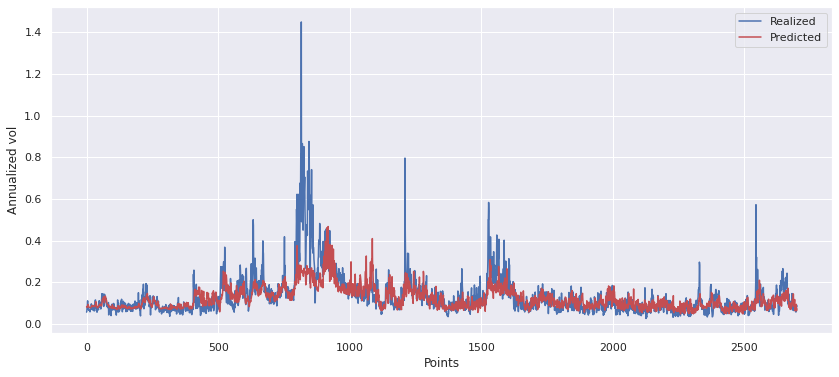

In [ ]:
DF = pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_LSTM1.csv',index_col=0)
fig, ax = plt.subplots(1,1,figsize=(14,6))
ax.set(xlabel="Points", ylabel="Annualized vol")
ax.plot(DF.Actual, "b", label="Realized")
ax.plot(DF.pred, "r", label="Predicted");
ax.legend();

#### Test avec un GRU : 

In [ ]:
batch_size = 64 ## Taille de chaque batch sur lequel il optimise 
neurons_lstm = 100 ; ## Nombre de neurones par couche LSTM
nb_epochs = 100 ## Nombre de fois ou on passe sur tout le dataset d entrainement
T_in = batch_size*20 ## Le nombre de samples pris pour chaque entrainement. 
dT= 100 # Nombre de points entre deux etapes de calibration

In [ ]:
Histo_GRU  = Global_GRU(batch_size,T_in,dT,nb_epochs,neurons_lstm,X_sample,y_sample,type = 'regression',shfle = False)

In [ ]:
# On Stock les resultats dans un csv
seq = np.arange(T_in,X_sample.shape[0]-T_in,dT) ; True_Vol = np.exp(X_full)[N_I + seq[0]:seq[-1]+N_I+dT] ; Histo_GRU = np.exp( Histo_GRU)
Results_GRU = pd.DataFrame.from_dict({'pred' : np.sqrt(Histo_GRU*252), 'Actual' : np.sqrt(True_Vol*252).flatten()})

In [ ]:
Results_GRU.to_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_GRU1.csv')

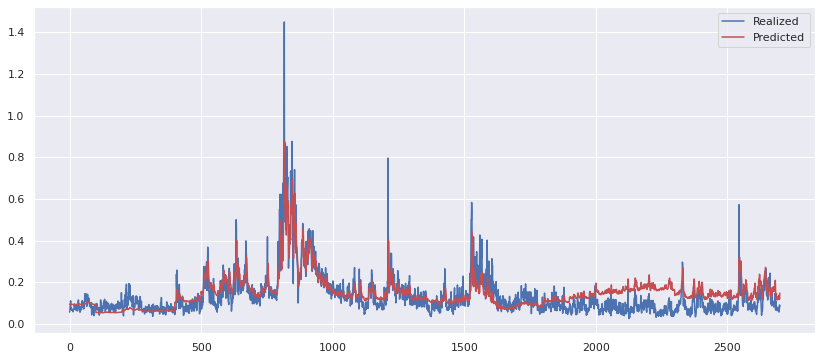

In [ ]:
DF = pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_GRU1.csv',index_col=0)
fig, ax = plt.subplots(1,figsize=(14,6))
ax.plot(DF.Actual, "b", label="Realized")
ax.plot(DF.pred, "r", label="Predicted");
ax.legend();

## 3 DL + modele

Commme nous ont montré les resultats de la partie precedente , il semble que le LSTM appliqué a la volatilité ne soit pas un bon predicteur.En effet es series fiancieres sont extremement bruité , le reseaux append la moyenne de la volatilité avec un preponderance sur les dernieres valeurs de la la series. 

Dans cette partie nous allons nous interesser a predir la volatiltié issue d'un model ou encore a etudier l'amelioration du pouvori predictif d'un model en entraineant le reseaux sur les residus plus que sur la serie. 

- Dans la premiere partie on entraine des reseaux reccurent sur des predicteur issues de modele comme la volatilité rough qui fit bien avec la serie de volatlité réalisée.

- Dans un second temps nous nous interessons à la prédiction del a volatiltié a travers un modéle et un reseaux de neurones. Cette approche consiste a expliquer une majeur partie des variations par un model de volatilité puis faire apprendre les residus à un reseaux de neurones.

### Predicteur : Rough Vol + Actual 

In [ ]:
vol_actuel = np.log(spx[["rk_twoscale"]][501:].values)
vol_rough = np.log(Baseline[['rough_pred']].values)
N_I = 100 
X_vol_act, y_sample = split_sequence_univariate(vol_actuel, N_I)
X_vol_rough, _ = split_sequence_univariate(vol_rough, N_I)
X_sample = np.concatenate((X_vol_rough,X_vol_act), axis=2)
X_sample.shape

(4694, 100, 2)

In [ ]:
batch_size = 64 ## Taille de chaque batch sur lequel il optimise 
neurons_lstm = 100 ; ## Nombre de neurones par couche LSTM
nb_epochs = 100 ## Nombre de fois ou on passe sur tout le dataset d entrainement
T_in = batch_size*20 ## Le nombre de samples pris pour chaque entrainement. 
dT= 100 # Nombre de points entre deux etapes de calibration 

#### Test LSTM : 

In [ ]:
History_Pred_LSTM = Global_LSTM(batch_size,T_in,dT,nb_epochs,neurons_lstm,X_sample,y_sample,type = 'regression',shfle = False)

In [ ]:
# On revient a la variance normale avec l'exp
seq = np.arange(T_in,X_sample.shape[0]-T_in,dT) ; True_Vol = np.exp(vol_actuel)[N_I + seq[0]:seq[-1]+N_I+dT] ; LSTM_Histo = np.exp(History_Pred_LSTM)
Results_LSTM = pd.DataFrame.from_dict({'pred' : np.sqrt(LSTM_Histo*252), 'Actual' : np.sqrt(True_Vol*252).flatten()})

In [ ]:
# On revient a la variance normale avec l'exp
seq = np.arange(T_in,X_sample.shape[0]-T_in,dT) ; True_Vol = np.exp(vol_actuel)[N_I + seq[0]:seq[-1]+N_I+dT] ; LSTM_Histo = np.exp(History_Pred_LSTM)
Results_LSTM = pd.DataFrame.from_dict({'pred' : np.sqrt(LSTM_Histo*252), 'Actual' : np.sqrt(True_Vol*252).flatten()})
Results_LSTM.to_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_LSTM_DL_et_mod.csv')

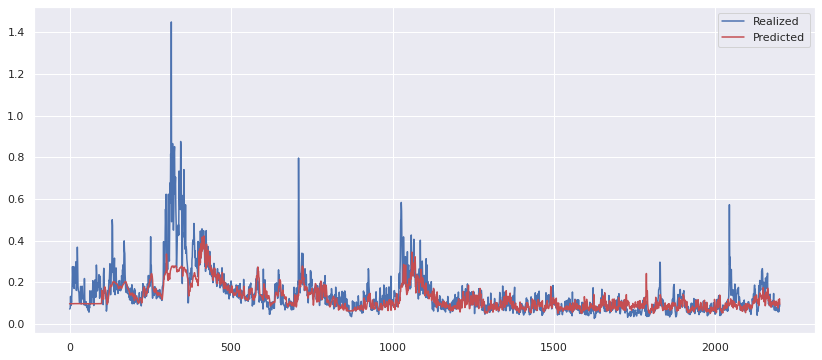

In [ ]:
DF = pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_LSTM_DL_et_mod.csv',index_col=0)
fig, ax = plt.subplots(1,figsize=(14,6))
ax.plot(DF.Actual, "b", label="Realized")
ax.plot(DF.pred, "r", label="Predicted");
ax.legend();

#### Test avec GRU : 


In [ ]:
History_Pred_GRU = Global_GRU(batch_size,T_in,dT,nb_epochs,neurons_lstm,X_sample,y_sample,type = 'regression',shfle = False)

In [ ]:
# On revient a la variance normale avec l'exp
seq = np.arange(T_in,X_sample.shape[0]-T_in,dT) ; True_Vol = np.exp(vol_actuel)[N_I + seq[0]:seq[-1]+N_I+dT] ; GRU_Histo = np.exp(History_Pred_GRU)
Results_GRU = pd.DataFrame.from_dict({'pred' : np.sqrt(GRU_Histo*252), 'Actual' : np.sqrt(True_Vol*252).flatten()})
Results_GRU.to_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_GRU_DL_et_Mod2.csv')

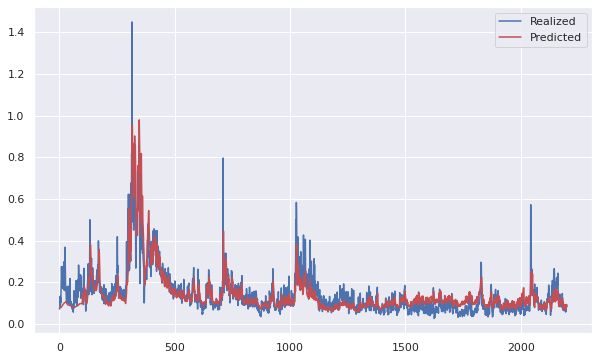

In [ ]:
DF = pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_GRU_DL_et_Mod2.csv',index_col=0)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(DF.Actual, "b", label="Realized")
ax.plot(DF.pred, "r", label="Predicted");
ax.legend();

### Residus Learning : $ log(\sigma_{rough})  - log(\sigma_{realized})$

In [ ]:
Baseline['Residual'] = (np.log(Baseline['rough_pred']) - np.log(Baseline['vol_actual']))

In [ ]:
vol_actuel = np.log(spx[["rk_twoscale"]][501:].values)
vol_res = Baseline[['Residual']].values
N_I = 100 
X_vol_act, y_sample = split_sequence_univariate(vol_actuel, N_I)
X_vol_res, _ = split_sequence_univariate(vol_res, N_I)
X_sample = np.concatenate((X_vol_act,X_vol_res), axis=2)
X_sample.shape

(4694, 100, 2)

In [ ]:
batch_size = 64 ## Taille de chaque batch sur lequel il optimise 
neurons_lstm = 100 ; ## Nombre de neurones par couche LSTM
nb_epochs = 100 ## Nombre de fois ou on passe sur tout le dataset d entrainement
T_in = batch_size*20 ## Le nombre de samples pris pour chaque entrainement. 
dT= 100 # Nombre de points entre deux etapes de calibration

#### Test LSTM : 

In [ ]:
History_Pred_LSTM = Global_LSTM(batch_size,T_in,dT,nb_epochs,neurons_lstm,X_sample,y_sample,type = 'regression',shfle = False)

In [ ]:
# On revient a la variance normale avec l'exp
seq = np.arange(T_in,X_sample.shape[0]-T_in,dT) ; True_Vol = np.exp(vol_actuel)[N_I + seq[0]:seq[-1]+N_I+dT] ; LSTM_Histo = np.exp(History_Pred_LSTM)
Results_LSTM = pd.DataFrame.from_dict({'pred' : np.sqrt(LSTM_Histo*252), 'Actual' : np.sqrt(True_Vol*252).flatten()})

In [ ]:
# On revient a la variance normale avec l'exp
seq = np.arange(T_in,X_sample.shape[0]-T_in,dT) ; True_Vol = np.exp(vol_actuel)[N_I + seq[0]:seq[-1]+N_I+dT] ; LSTM_Histo = np.exp(History_Pred_LSTM)
Results_LSTM = pd.DataFrame.from_dict({'pred' : np.sqrt(LSTM_Histo*252), 'Actual' : np.sqrt(True_Vol*252).flatten()})
Results_LSTM.to_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_LSTM_residus.csv')

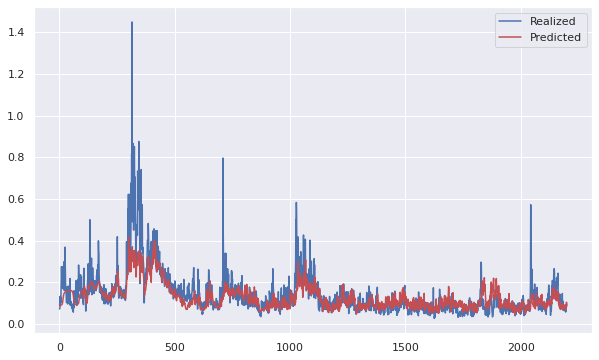

In [ ]:
DF = pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_LSTM_residus.csv',index_col=0)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(DF.Actual, "b", label="Realized")
ax.plot(DF.pred, "r", label="Predicted");
ax.legend();

#### Test GRU : 

In [ ]:
History_Pred_GRU = Global_GRU(batch_size,T_in,dT,nb_epochs,neurons_lstm,X_sample,y_sample,type = 'regression',shfle = False)

In [ ]:
# On revient a la variance normale avec l'exp
seq = np.arange(T_in,X_sample.shape[0]-T_in,dT) ; True_Vol = np.exp(vol_actuel)[N_I + seq[0]:seq[-1]+N_I+dT] ; GRU_Histo = np.exp(History_Pred_GRU)
Results_GRU = pd.DataFrame.from_dict({'pred' : np.sqrt(GRU_Histo*252), 'Actual' : np.sqrt(True_Vol*252).flatten()})
Results_GRU.to_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_GRU_residus.csv')

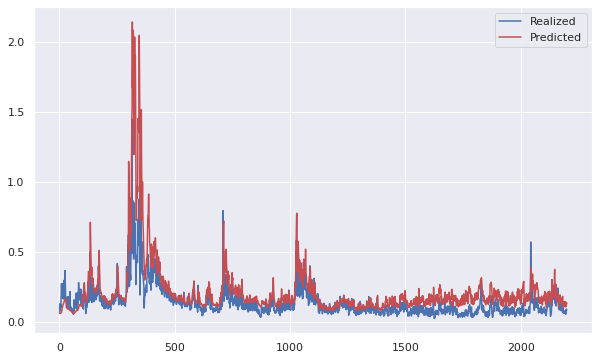

In [ ]:
DF = pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_GRU_residus.csv',index_col=0)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(DF.Actual, "b", label="Realized")
ax.plot(DF.pred, "r", label="Predicted");
ax.legend();

## Comapraison 

### Comparaison des approches :

> On va comparer la rootmean squared error pour chaque Modéle  et pour chaque architecture



### GRU

In [120]:
from sklearn.metrics import mean_squared_error
Mod1 = pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_GRU1.csv',index_col=0)
Mod2 = pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_GRU_DL_et_Mod2.csv',index_col=0)
Mod3 =pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_GRU_residus.csv',index_col=0)

In [121]:
MSE_mod1 = mean_squared_error(Mod1.pred,Mod1.Actual)
MSE_mod2 = mean_squared_error(Mod2.pred,Mod2.Actual)
MSE_mod3 = mean_squared_error(Mod3.pred,Mod3.Actual)

In [122]:
print(f"MSE GRU vol realized : {MSE_mod1}")
print(f"MSE GRU vol realized + rough : {MSE_mod2}")
print(f"MSE GRU vol realized + rough + residus : {MSE_mod3}")

MSE GRU vol realized : 0.004202001956483483
MSE GRU vol realized + rough : 0.0040936961748876755
MSE GRU vol realized + rough + residus : 0.026012972674077765


> Le meilleur modéle est celui utilisant la vol réalisée et le modéle "rough".

---



### LSTM

In [123]:
Mod1 = pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_LSTM1.csv',index_col=0)
Mod2 = pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_LSTM_DL_et_mod.csv',index_col=0)
Mod3 =pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_LSTM_residus.csv',index_col=0)

In [124]:
MSE_mod1 = mean_squared_error(Mod1.pred,Mod1.Actual)
MSE_mod2 = mean_squared_error(Mod2.pred,Mod2.Actual)
MSE_mod3 = mean_squared_error(Mod3.pred,Mod3.Actual)

In [125]:
print(f"MSE LSTM vol realized : {MSE_mod1}")
print(f"MSE LSTM vol realized + rough  : {MSE_mod2}")
print(f"MSE LSTM vol realized + rough + residus : {MSE_mod3}")

MSE LSTM vol realized : 0.005585967669816807
MSE LSTM vol realized + rough  : 0.006266729747143105
MSE LSTM vol realized + rough + residus : 0.005667697044695684


> Le meilleur modéle est celui utilisant la vol réalisée.

### Some additional predictors

> On utilise un nouveau feature qui nous correspond à l'évenement , le jour actuel est une 3 ième Vendredi du mois.

$\textbf{NB}$ : $\textit{Journée des 4 sorcières}$:

issue de : https://www.cafedelabourse.com/lexique/definition/jour-des-3-sorcieres

Le « Jour des trois sorcières » désigne en finance la journée d’expiration de trois types de contrats.

Le jour des trois sorcières survient lorsque les contrats futures sur indices, les contrats d’options sur indices et les contrats d’options sur actions arrivent simultanément à échéance.

La dernière heure de la séance du jour des trois sorcières est souvent plus volatile que d’habitude, car les traders bouclent souvent leurs positions sur futures et options juste avant la fin de la journée.

In [96]:
Baseline

,Dates,vol_actual,rough_pred
0,2002-01-08 00:00:00+00:00,0.000064,0.000060
1,2002-01-09 00:00:00+00:00,0.000061,0.000065
2,2002-01-10 00:00:00+00:00,0.000066,0.000065
3,2002-01-11 00:00:00+00:00,0.000040,0.000068
4,2002-01-14 00:00:00+00:00,0.000053,0.000054
...,...,...,...
4789,2021-02-09 00:00:00+00:00,0.000055,0.000019
4790,2021-02-10 00:00:00+00:00,0.000032,0.000039
4791,2021-02-11 00:00:00+00:00,0.000013,0.000035
4792,2021-02-12 00:00:00+00:00,0.000032,0.000023


In [97]:
vol_actuel = np.log(spx[["rk_twoscale"]][501:].values)

In [98]:
from datetime import datetime

In [99]:
def is_third_friday(s):
    d = datetime.strptime(s, '%Y-%m-%d')
    return d.weekday() == 4 and 15 <= d.day <= 21

def add_is_third_friday_feature(Tab):
  is3rd = list() ; 
  for i in range(Tab.shape[0]):
    if is_third_friday(Tab.Dates[i].split()[0]):
      is3rd.append(1)
    else:
      is3rd.append(0)
  Tab['is3rdFriday'] = is3rd
  return Tab

In [101]:
Baseline = add_is_third_friday_feature(Baseline)

In [102]:
Baseline

,Dates,vol_actual,rough_pred,is3rdFriday
0,2002-01-08 00:00:00+00:00,0.000064,0.000060,0
1,2002-01-09 00:00:00+00:00,0.000061,0.000065,0
2,2002-01-10 00:00:00+00:00,0.000066,0.000065,0
3,2002-01-11 00:00:00+00:00,0.000040,0.000068,0
4,2002-01-14 00:00:00+00:00,0.000053,0.000054,0
...,...,...,...,...
4789,2021-02-09 00:00:00+00:00,0.000055,0.000019,0
4790,2021-02-10 00:00:00+00:00,0.000032,0.000039,0
4791,2021-02-11 00:00:00+00:00,0.000013,0.000035,0
4792,2021-02-12 00:00:00+00:00,0.000032,0.000023,0


In [104]:
Baseline['Residual'] = (np.log(Baseline['vol_actual']) - np.log(Baseline['rough_pred']))

In [105]:
Baseline.vol_actual = np.log(Baseline.vol_actual)
Baseline.rough_pred = np.log(Baseline.rough_pred)

In [106]:
Baseline

,Dates,vol_actual,rough_pred,is3rdFriday,Residual
0,2002-01-08 00:00:00+00:00,-9.650041,-9.725695,0,0.075654
1,2002-01-09 00:00:00+00:00,-9.712316,-9.643008,0,-0.069308
2,2002-01-10 00:00:00+00:00,-9.630857,-9.646218,0,0.015361
3,2002-01-11 00:00:00+00:00,-10.135623,-9.598634,0,-0.536989
4,2002-01-14 00:00:00+00:00,-9.844511,-9.831486,0,-0.013026
...,...,...,...,...,...
4789,2021-02-09 00:00:00+00:00,-9.810574,-10.868215,0,1.057642
4790,2021-02-10 00:00:00+00:00,-10.354145,-10.155547,0,-0.198597
4791,2021-02-11 00:00:00+00:00,-11.268949,-10.248489,0,-1.020460
4792,2021-02-12 00:00:00+00:00,-10.337996,-10.701010,0,0.363014


In [107]:
X_full = Baseline[['rough_pred','Residual','is3rdFriday','vol_actual']].values                     # note the [[]] here. Otherwise, reshape(...,1)
X_full.shape ; N_I=100 # length of sequences input to LSTMs
X_sample,y_sample = split_sequences_multivariate(X_full,N_I)   # for LSTMs
print(X_sample.shape)# we do have a 3d-object
print(y_sample.shape)

(4694, 100, 4)
(4694,)


In [108]:
batch_size = 64 ## Taille de chaque batch sur lequel il optimise 
neurons_lstm = 100 ; ## Nombre de neurones par couche LSTM
nb_epochs = 100 ## Nombre de fois ou on passe sur tout le dataset d entrainement
T_in = batch_size*20 ## Le nombre de samples pris pour chaque entrainement. 
dT= 100 # Nombre de points entre deux etapes de calibration

#### LSTM : 

In [109]:
History_Pred_LSTM = Global_LSTM(batch_size,T_in,dT,nb_epochs,neurons_lstm,X_sample,y_sample,type = 'regression',shfle = False)

In [111]:
# On revient a la variance normale avec l'exp
seq = np.arange(T_in,X_sample.shape[0]-T_in,dT) ; True_Vol = np.exp(vol_actuel)[N_I + seq[0]:seq[-1]+N_I+dT] ; LSTM_Histo = np.exp(History_Pred_LSTM)
Results_LSTM = pd.DataFrame.from_dict({'pred' : np.sqrt(LSTM_Histo*252), 'Actual' : np.sqrt(True_Vol*252).flatten()})
Results_LSTM.to_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_LSTM_All_features.csv')

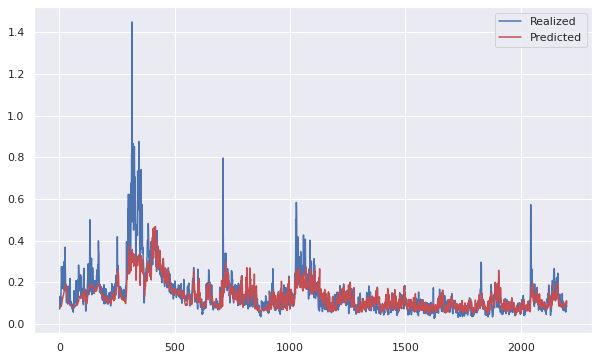

In [112]:
DF = pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_LSTM_All_features.csv',index_col=0)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(DF.Actual, "b", label="Realized")
ax.plot(DF.pred, "r", label="Predicted");
ax.legend();

#### GRU :

In [113]:
History_Pred_GRU = Global_GRU(batch_size,T_in,dT,nb_epochs,neurons_lstm,X_sample,y_sample,type = 'regression',shfle = False)

In [126]:
# On revient a la variance normale avec l'exp
seq = np.arange(T_in,X_sample.shape[0]-T_in,dT) ; True_Vol = np.exp(vol_actuel)[N_I + seq[0]:seq[-1]+N_I+dT] ; GRU_Histo = np.exp(History_Pred_GRU)
Results_GRU = pd.DataFrame.from_dict({'pred' : np.sqrt(GRU_Histo*252), 'Actual' : np.sqrt(True_Vol*252).flatten()})
Results_GRU.to_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_GRU_All_features.csv')

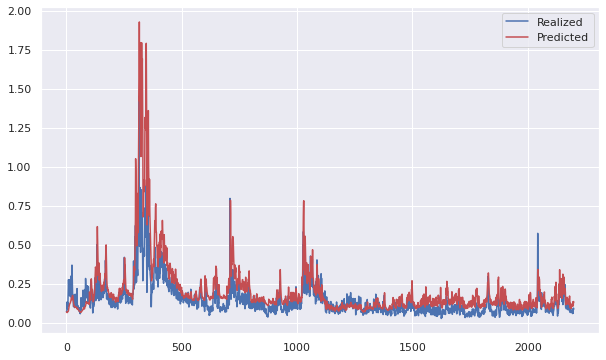

In [127]:
DF = pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_GRU_All_features.csv',index_col=0)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(DF.Actual, "b", label="Realized")
ax.plot(DF.pred, "r", label="Predicted");
ax.legend();

#### Resultats GRU et LSTM : 

In [128]:
from sklearn.metrics import mean_squared_error

In [129]:
Mod4_GRU = pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_GRU_All_features.csv',index_col=0)
Mod4_LSTM = pd.read_csv('/content/drive/MyDrive/Centrale Supelec/DeepLearningFinance/TD5/Vol_Prev_LSTM_All_features.csv',index_col=0)

In [130]:
MSE_Mod4_GRU = mean_squared_error(Mod4_GRU.pred,Mod4_GRU.Actual)
MSE_Mod4_LSTM= mean_squared_error(Mod4_LSTM.pred,Mod4_LSTM.Actual)

In [131]:
print(f"MSE GRU  Vol real + rough + res + 3rdFriday  : {MSE_Mod4_GRU}")
print(f"MSE LSTM Vol real + rough + res + 3rdFriday : {MSE_Mod4_LSTM}")

MSE GRU  Vol real + rough + res + 3rdFriday  : 0.01811767894783756
MSE LSTM Vol real + rough + res + 3rdFriday : 0.005505866174762561


> On observe que l'introduction de ce feature n'améliore pas la MSE.En effet les meilleurs resultats sont obtenus avec le GRU en utilisant la vol realisée et le vol rough ( MSE de 0.00409).